### ПОДГРУЗКА БИБЛИОТЕК

In [ ]:
!pip install -r requirements.txt

In [140]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

### ПОДГОТОВКА ДАННЫХ

In [141]:
# ПОДГОТОВКА ДАННЫХ
df = pd.read_csv('IoT_Intrusion.csv')
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df['label'].value_counts().head(10))

Dataset shape: (1048575, 47)
Columns: ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label']
label
DDoS-ICMP_Flood            161281
DDoS-UDP_Flood             121205
DDoS-TCP_Flood             101293
DDoS-PSHACK_Flood           92395
DDoS-SYN_Flood              91644
DDoS-RSTFINFlood            90823
DDoS-SynonymousIP_Flood     80680
DoS-UDP_Flood               74787
DoS-TCP_Flood               59807
DoS-SYN_Flood               45207
Name: count, dtype: int64


In [142]:
df['label'] = df['label'].apply(lambda x: x.split("-")[0])
df['label'].unique()

array(['DDoS', 'DoS', 'Mirai', 'BenignTraffic', 'MITM', 'Recon',
       'DNS_Spoofing', 'XSS', 'CommandInjection', 'VulnerabilityScan',
       'Backdoor_Malware', 'BrowserHijacking', 'DictionaryBruteForce',
       'SqlInjection', 'Uploading_Attack'], dtype=object)

In [143]:
# Сохраним копии базы для дальнейшего анализа всех видов атак
df_ddos = df.copy()
df_mitm = df.copy()
df_mirai = df.copy()
df_spoofing = df.copy()
df_sqli = df.copy()

In [144]:
# Выделяем среди всех типов атак DoS-атаки.
df['label'] = df['label'].apply(lambda x: 1 if x.startswith('DoS') else 0)
print(df['label'].value_counts())

label
0    867094
1    181481
Name: count, dtype: int64


In [145]:
# РАЗМЕТКА ДАННЫХ 
X = df.drop(columns=['label'])
y = df['label']

In [146]:
# НОРМАЛИЗАЦИЯ
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

### ОБУЧЕНИЕ МОДЕЛИ

In [147]:
# РАЗДЕЛЕНИЕ НА ТРЕНИРОВОЧНУЮ И ТЕСТОВУЮ ВЫБОРКИ 
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [148]:
# ОБУЧЕНИЕ МОДЕЛИ 
model = RandomForestClassifier(n_estimators=7, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=7, random_state=42)

In [149]:
# МЕТРИКИ НА ТЕСТОВОЙ ВВЫБОРКЕ 
pred = model.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    173419
           1       1.00      1.00      1.00     36296

    accuracy                           1.00    209715
   macro avg       1.00      1.00      1.00    209715
weighted avg       1.00      1.00      1.00    209715



### ВЫЧИСЛЕНИЕ КЛЮЧЕВЫХ ПАРАМЕТРОВ

In [150]:
# ПОДСЧЕТ SHAP 
# Создаём объект SHAP-объяснителя на основе обученной модели дерева 
explainer = shap.TreeExplainer(model)

# Случайным образом выбираем 1000 примеров из тестовой выборки
# Это нужно для оценки и визуализации вклада признаков
sample = X_test.sample(n=1000, random_state=42)

# Вычисляем SHAP-значения для выбранных примеров
# Результат: массив размерности (1000, num_features, num_classes)
# Показывает, как каждый признак влияет на предсказание для каждого класса
shap_values = explainer.shap_values(sample) 

In [151]:
def shap_research(shap_values, sample, class_index=1, top_n=30, show_waterfall=False, sample_index=0):
    """
    Анализирует и визуализирует важность признаков на основе SHAP-значений для заданного класса (по умолчанию — DoS).
    
    Параметры:
    - shap_values: SHAP-значения от TreeExplainer (массив или список массивов)
    - sample: DataFrame с примерами, для которых были рассчитаны SHAP-значения
    - class_index: номер класса для анализа (по умолчанию 1 — DoS)
    - top_n: сколько признаков отобразить в bar-графике
    - show_waterfall: отобразить ли waterfall-график для одного примера
    - sample_index: индекс примера для waterfall-графика (если включено)
    
    Возвращает:
    - Список признаков в порядке убывания важности
    """

    # Выбираем SHAP-значения для нужного класса
    if isinstance(shap_values, list):
        sv = shap_values[class_index]  # SHAP для класса class_index
    else:
        sv = shap_values

    # Если размерность (n, features, classes), выделяем только нужный класс
    if sv.ndim == 3:
        sv = sv[:, :, class_index]

    # Считаем среднее абсолютное SHAP-значение для каждого признака
    mean_shap = np.abs(sv).mean(axis=0)
    if len(mean_shap.shape) > 1:
        mean_shap = mean_shap.squeeze()

    # Формируем DataFrame с признаками и их средними SHAP-важностями
    shap_df = pd.DataFrame({
        'Feature': sample.columns,
        'Mean_SHAP_Impact': mean_shap
    }).sort_values(by='Mean_SHAP_Impact', ascending=False)

    # Отбираем топ-N признаков
    top_feats = shap_df.head(top_n)

    # Визуализация важности признаков (bar chart) 
    plt.figure(figsize=(10, 6))
    plt.barh(top_feats['Feature'][::-1], top_feats['Mean_SHAP_Impact'][::-1])
    plt.xlabel('Среднее |SHAP значение|') 
    plt.title(f'График важности признаков (топ {top_n})')
    plt.tight_layout()
    plt.show()

    # Waterfall-график для одного примера 
    if show_waterfall:
        print(f"\nWaterfall-график для sample_index = {sample_index}")
        shap.plots.waterfall(shap.Explanation(
            values=sv[sample_index],
            base_values=shap_values.base_values[class_index] if hasattr(shap_values, 'base_values') else 0,
            data=sample.iloc[sample_index],
            feature_names=sample.columns.tolist()
        ), max_display=14)

    # Возвращаем список признаков по убыванию важности
    return shap_df['Feature'].tolist()


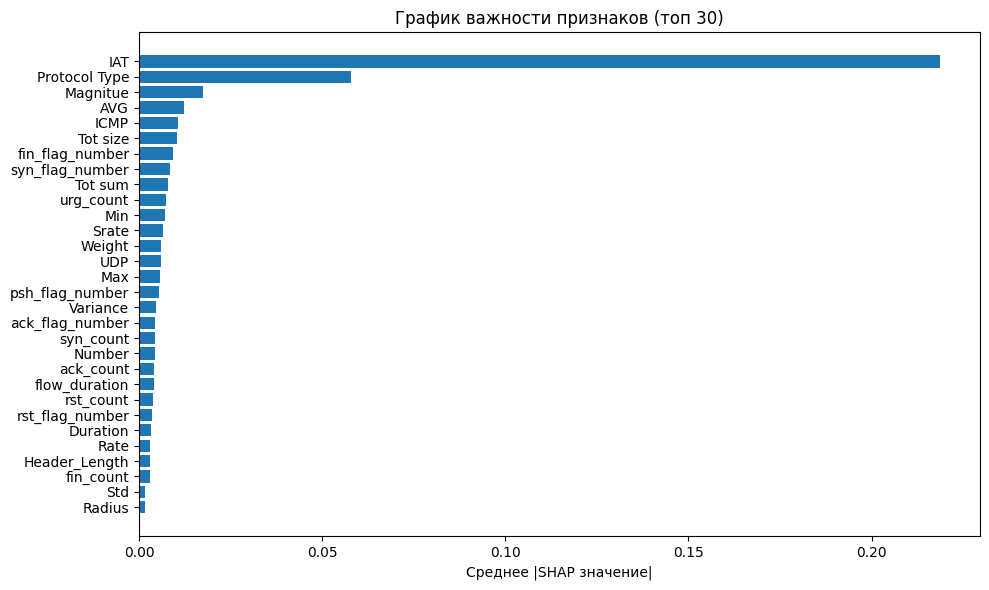


Waterfall-график для sample_index = 0


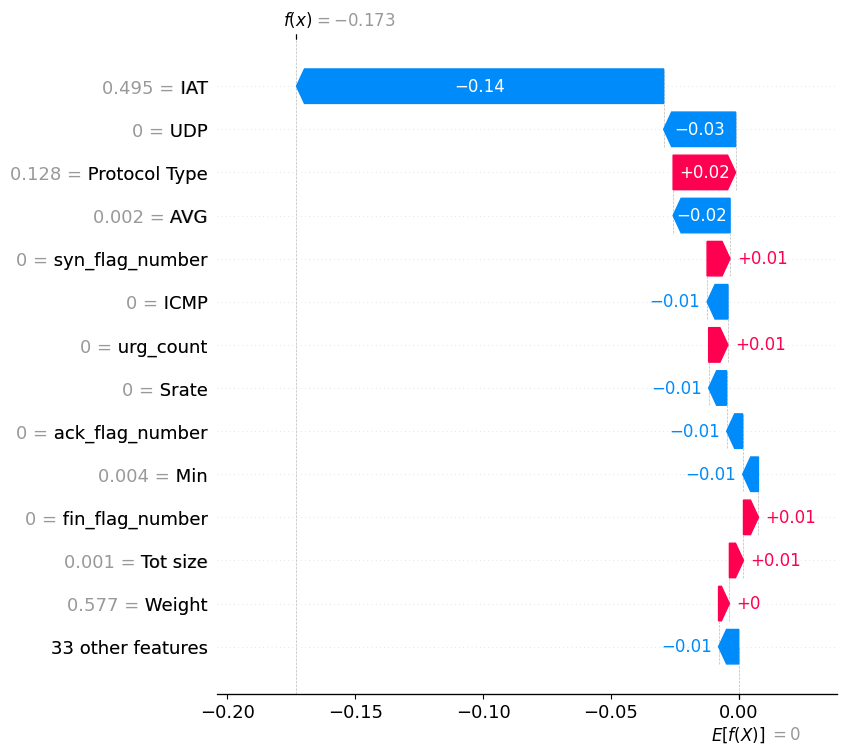

In [152]:
# График важности параметров
top_shap = shap_research(shap_values, sample, show_waterfall=True)

In [153]:
# ВАЖНЫЕ ПРИЗНАКИ ПО SHAP 
ordered_features = top_shap[:5]
ordered_features

['IAT', 'Protocol Type', 'Magnitue', 'AVG', 'ICMP']

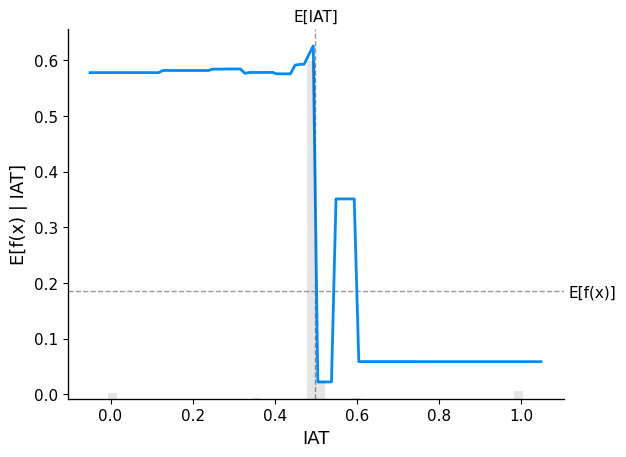

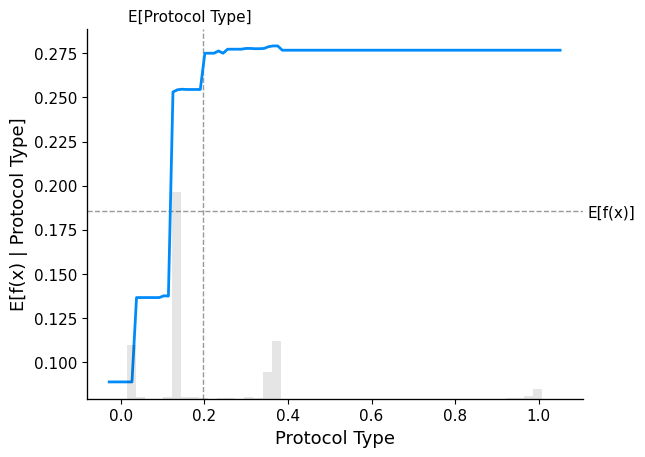

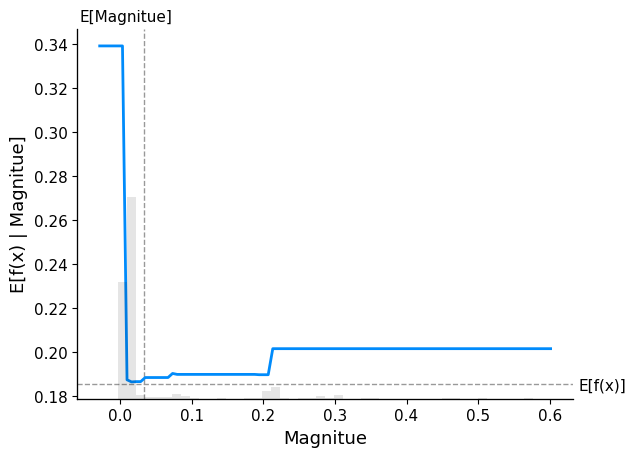

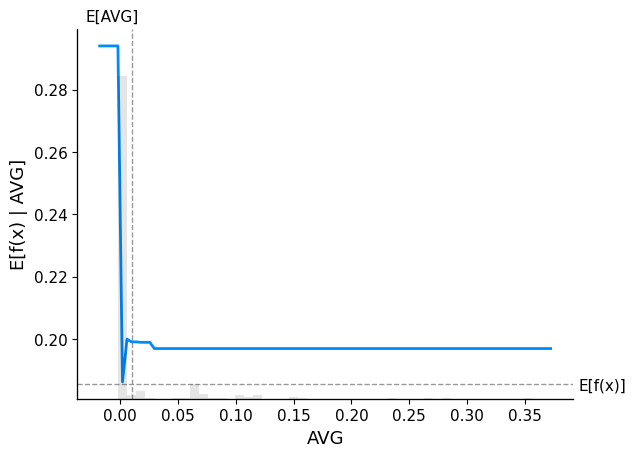

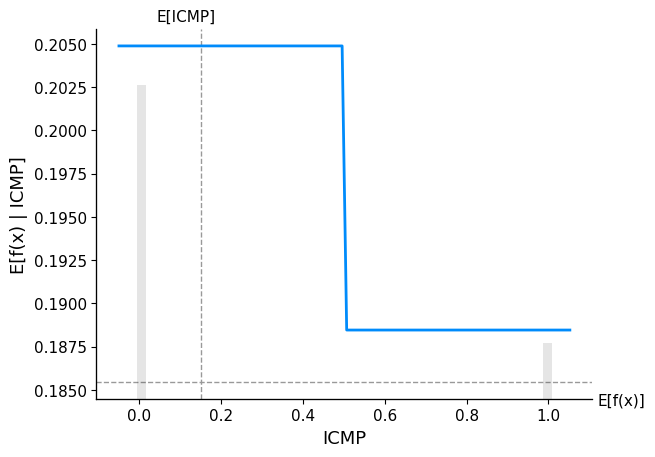

In [155]:
# Выбираем сэмпл
X_sample = X_test.sample(n=1000, random_state=42)

# Подсчтет SHAP значений
explainer = shap.Explainer(model, X_sample)
shap_values = explainer(X_sample)

# Функция предсказания вероятностей для класса 1
predict_proba_fn = lambda X: model.predict_proba(X)[:, 1]

# Визуализация
for feature in ordered_features[:]:
    try:
        shap.partial_dependence_plot(
            feature,
            predict_proba_fn,
            X_sample,
            model_expected_value=True,
            feature_expected_value=True,
            show=False,
            ice=False,
            shap_values=shap_values
        )
        plt.title(f"SHAP Partial Dependence for {feature}")
        plt.show()
    except:
        continue

### ГЕНЕРАЦИЯ КОНТРФАКТОВ

#### Cдвиг на фиксированный шаг важных параметров

Рассмотрим генерацию контрфактов на основе сдвига на фиксированный шаг значений важных параметров.

In [156]:
# КОНТРФАКТИЧЕСКАЯ ГЕНЕРАЦИЯ 
def greedy_generator(x, model, features, max_iter=100, step=0.005):
    x = x.copy()  # Создаём копию входного вектора, чтобы не изменять оригинал
    original_class = model.predict([x])[0]  # Определяем исходный класс
    target_class = 1 - original_class       # Желаемый (противоположный) класс
    changed_features = []  # Список важных признаков

    for _ in range(max_iter):  # Пытаемся изменить максимум max_iter раз
        probas = model.predict_proba([x])[0]  # Получаем вероятности классов
        if np.argmax(probas) == target_class:
            break  # Если достигли нужного класса — выходим

        best_feature = None     # Лучший признак для изменения
        best_change = None      # Направление и величина изменения
        best_score = probas[target_class]  # Текущая вероятность нужного класса

        for f in features:  # Перебираем указанные признаки
            idx = X.columns.get_loc(f)  # Получаем индекс признака в массиве
            for direction in [-1, 1]:  # Пробуем уменьшить и увеличить
                x_temp = x.copy()
                # Изменяем признак в выбранную сторону
                x_temp[idx] = np.clip(x_temp[idx] + direction * step, 0, 1)
                new_proba = model.predict_proba([x_temp])[0][target_class]
                # Если изменение улучшает вероятность нужного класса — запоминаем
                if new_proba > best_score:
                    best_score = new_proba
                    best_feature = idx
                    best_change = direction * step

        if best_feature is None:
            break  # Если ни одно изменение не помогло — остановка

        # Применяем лучшее изменение
        x[best_feature] = np.clip(x[best_feature] + best_change, 0, 1)
        changed_features.append(X.columns[best_feature])  # Запоминаем, что изменили

    # Возвращаем модифицированную строку, новый класс и список изменённых признаков
    new_class = model.predict([x])[0]
    return x, new_class, changed_features


In [157]:
# ПРОВЕРКА ТОЛЬКО ДЛЯ ЦЕЛЕВОГО КЛАССА 1 (DoS) 
# Берём первые 100 индексов из тестовой выборки, где y == 1 (DoS)
idx_target = y_test[y_test == 1].index[:100]

results = []            # Список для хранения результатов генерации
feature_names = X_test.columns.tolist()  # Имена признаков
delta_matrix = []       # Изменения между оригиналом и контрфактом (вектор разностей)
successful_cfs = []     # Успешные контрфакты (те, где класс изменился)

# Проходим по каждой записи с классом 1
for i in idx_target:
    x0 = X_test.loc[i].values       # Вектор признаков (в виде массива)
    x1 = X_test.loc[[i]]            # Вектор признаков (в виде DataFrame, для model.predict)
    y_true = y_test.loc[i]          # Истинная метка
    orig_pred = model.predict([x0])[0]  # Предсказанный моделью класс до изменений

    # Генерация контрфакта: изменяем признаки, чтобы поменять решение модели
    x_cf, cf_pred, changed_feats = greedy_generator(
        x0, model, ordered_features
    )

    # Преобразуем исходные и контрфактические вектора в Series для удобства сравнения
    original = pd.Series(x0, index=feature_names)
    cf_series = pd.Series(x_cf, index=feature_names)

    # Если удалось добиться смены класса, сохраняем результат
    if orig_pred != cf_pred:
        successful_cfs.append(x_cf)                   # Сохраняем успешный контрфакт
        delta = np.abs(x_cf - x0)                     # Вычисляем поэлементную разницу
        delta_matrix.append(delta)                    # Сохраняем в матрицу изменений

    # Вывод: сравнение предсказаний до и после изменений
    print("\nИсходный класс:", model.predict(x1)[0], "→ Контрфакт предсказан как:", cf_pred)

    # Формируем DataFrame с оригиналом и контрфактом для визуального сравнения
    original = pd.Series(x1.values[0], index=feature_names, name="Оригинал")
    cf_series = pd.Series(x_cf, index=feature_names, name="Контрфакт")
    comparison = pd.concat([original, cf_series], axis=1)

    # Выводим только те признаки, которые были изменены
    print("\nИзменённые признаки:\n", comparison[comparison['Оригинал'] != comparison['Контрфакт']])

    # Сохраняем итоги в таблицу результатов
    results.append({
        'true_class': y_true,                   # Истинный класс
        'original_class': orig_pred,            # Предсказание до изменений
        'cf_class': cf_pred,                    # Предсказание после изменений
        'changed_count': len(changed_feats),    # Сколько признаков было изменено
        'changed_features': changed_feats,      # Какие признаки были изменены
        'success': int(orig_pred != cf_pred)    # Был ли успешен контрфакт (1 — да, 0 — нет)
    })

# Финальный DataFrame со сводкой по всем запускам
results_df = pd.DataFrame(results)



Исходный класс: 1 → Контрфакт предсказан как: 0

Изменённые признаки:
      Оригинал  Контрфакт
IAT  0.494796   0.499796

Исходный класс: 1 → Контрфакт предсказан как: 0

Изменённые признаки:
      Оригинал  Контрфакт
IAT  0.495207   0.500207

Исходный класс: 1 → Контрфакт предсказан как: 0

Изменённые признаки:
      Оригинал  Контрфакт
IAT  0.494663   0.499663

Исходный класс: 1 → Контрфакт предсказан как: 0

Изменённые признаки:
      Оригинал  Контрфакт
IAT  0.494792   0.499792

Исходный класс: 1 → Контрфакт предсказан как: 0

Изменённые признаки:
      Оригинал  Контрфакт
IAT  0.495022   0.500022

Исходный класс: 1 → Контрфакт предсказан как: 0

Изменённые признаки:
      Оригинал  Контрфакт
IAT  0.494821   0.499821

Исходный класс: 1 → Контрфакт предсказан как: 0

Изменённые признаки:
      Оригинал  Контрфакт
IAT  0.494668   0.499668

Исходный класс: 1 → Контрфакт предсказан как: 0

Изменённые признаки:
      Оригинал  Контрфакт
IAT  0.494848   0.499848

Исходный класс: 1 → Кон

In [158]:
# ОТЧЁТ 
print(f"Успешных атак на класс '1' (DoS): {results_df['success'].sum()} из {len(results_df)}")
print(results_df[['true_class', 'original_class', 'cf_class', 'changed_count', 'changed_features']])

Успешных атак на класс '1' (DoS): 97 из 100
    true_class  original_class  cf_class  changed_count changed_features
0            1               1         0              1            [IAT]
1            1               1         0              1            [IAT]
2            1               1         0              1            [IAT]
3            1               1         0              1            [IAT]
4            1               1         0              1            [IAT]
..         ...             ...       ...            ...              ...
95           1               1         0              1            [IAT]
96           1               1         0              1            [IAT]
97           1               1         0              1            [IAT]
98           1               1         0              1            [IAT]
99           1               1         0              1            [IAT]

[100 rows x 5 columns]


In [159]:
# МЕТРИКИ 
print("Метрики ДО:")
print(classification_report(results_df['true_class'], results_df['original_class']))
print("Метрики ПОСЛЕ:")
print(classification_report(results_df['true_class'], results_df['cf_class']))

Метрики ДО:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Метрики ПОСЛЕ:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.03      0.06       100

    accuracy                           0.03       100
   macro avg       0.50      0.01      0.03       100
weighted avg       1.00      0.03      0.06       100



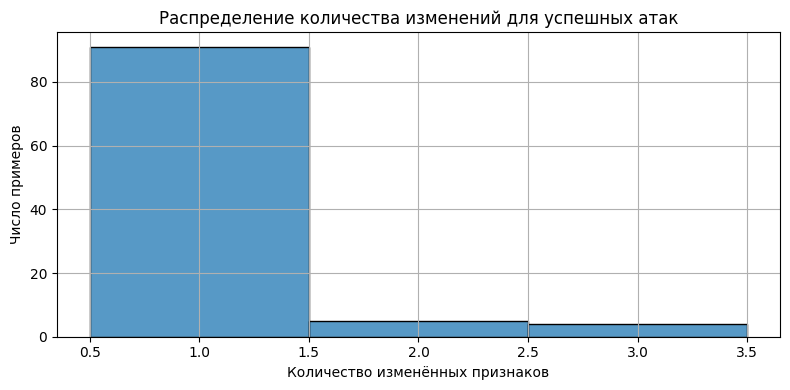

In [160]:
# ВИЗУАЛИЗАЦИЯ 
plt.figure(figsize=(8, 4))
sns.histplot(results_df['changed_count'], bins=range(0, max(results_df['changed_count']) + 2), discrete=True)
plt.xlabel("Количество изменённых признаков")
plt.ylabel("Число примеров")
plt.title("Распределение количества изменений для успешных атак")
plt.grid(True)
plt.tight_layout()
plt.show()

In [161]:
# СРЕДНЕЕ ИЗМЕНЕНИЕ ПРИЗНАКОВ (только для успешных контрфактов) 

# Проверяем, есть ли хотя бы один успешный контрфакт
if delta_matrix:
    # Преобразуем список векторов изменений в NumPy-массив (матрицу N x D)
    delta_matrix = np.array(delta_matrix)

    # Считаем среднее абсолютное изменение по каждому признаку (успешные только)
    mean_delta = delta_matrix.mean(axis=0)

    # Оборачиваем результат в pandas.Series с названиями признаков и сортируем по убыванию
    mean_delta_series = pd.Series(mean_delta, index=feature_names).sort_values(ascending=False)

    # Выводим только те признаки, которые действительно менялись (> 0)
    print("Среднее абсолютное изменение признаков (только успешные атаки):")
    print(mean_delta_series[mean_delta_series > 0].round(4))

else:
    # Если успешных атак не было — ничего не рассчитываем
    print("Нет успешных атак — среднее изменение признаков не рассчитывается.")


Среднее абсолютное изменение признаков (только успешные атаки):
IAT         0.0050
Magnitue    0.0005
AVG         0.0002
dtype: float64


#### На основе успешных контрфактов

Рассмотрим теперь генерацию синтетичесих примеров на основе успешных контрфактов.


In [162]:
# ГЕНЕРАЦИЯ СИНТЕТИЧЕСКИХ ПРИМЕРОВ НА ОСНОВЕ КОНТРФАКТОВ 

def generate_synthetic_samples(successful_cfs, n_samples=50, random_state=42):
    """
    Генерирует синтетические примеры на основе успешных контрфактов:
    - Считается среднее значение (mu) и стандартное отклонение (sigma)
    - Создаются новые точки из нормального распределения N(mu, sigma)
    
    Параметры:
    - successful_cfs: список успешных контрфактов
    - n_samples: сколько синтетических примеров сгенерировать
    - random_state: фиксируем сид для воспроизводимости

    Возвращает:
    - DataFrame с синтетическими примерами
    """
    np.random.seed(random_state)  # Устанавливаем сид для генератора случайных чисел

    # Преобразуем список контрфактов в DataFrame
    successful_cfs = pd.DataFrame(successful_cfs, columns=X_test.columns)

    # Считаем среднее и стандартное отклонение по каждому признаку
    mu = successful_cfs.mean()
    sigma = successful_cfs.std()

    # Генерируем новые значения из нормального распределения N(mu, sigma)
    synthetic_data = np.random.normal(
        loc=mu.values,             # среднее (по каждому признаку)
        scale=sigma.values,        # стандартное отклонение
        size=(n_samples, len(mu))  # размерность: n_samples x num_features
    )

    # Преобразуем массив обратно в DataFrame
    synthetic_df = pd.DataFrame(synthetic_data, columns=successful_cfs.columns)
    
    return synthetic_df

In [163]:
# Генерируем 100 синтетических объектов
synthetic_samples = generate_synthetic_samples(successful_cfs, n_samples=100)

# Прогоняем их через модель, чтобы узнать, как она классифицирует новые примеры
synthetic_preds = model.predict(synthetic_samples)

# Выводим, сколько из них модель определила как класс '1'
print(f"\nМодель классифицировала {sum(synthetic_preds == 1)} из 100 новых синтетических объектов как класс '1'")


Модель классифицировала 3 из 100 новых синтетических объектов как класс '1'


#### На основе SHAP

Рассмотрим теперь генерацию синтетичесих примеров на основе только наиболее важных признаков.

In [164]:
# ГЕНЕРАЦИЯ СИНТЕТИЧЕСКИХ ПРИМЕРОВ НА ОСНОВЕ SHAP 
def generate_synthetic_from_shap(X_base, top_features, n_samples=100, std_scale=1.0, random_state=42):
    """
    Генерирует синтетические примеры, варьируя только наиболее важные признаки (по SHAP).
    
    Параметры:
    - X_base: исходный DataFrame (обычно X_train)
    - top_features: список признаков, которые можно менять
    - n_samples: сколько примеров сгенерировать
    - std_scale: масштаб разброса (относительно стандартного отклонения)
    - random_state: для воспроизводимости
    
    Возвращает:
    - DataFrame с синтетическими объектами
    """
    np.random.seed(random_state)

    # Средние и стандартные отклонения по каждому признаку
    mu = X_base.mean()
    sigma = X_base.std()

    synthetic_data = []

    for _ in range(n_samples):
        sample = mu.copy()  # Начинаем с усреднённого объекта
        for feat in top_features:
            # Изменяем только важные признаки: добавляем шум с нормальным распределением
            sample[feat] = np.random.normal(mu[feat], std_scale * sigma[feat])
        synthetic_data.append(sample.values)  # Добавляем пример в выборку

    # Возвращаем в виде DataFrame
    synthetic_df = pd.DataFrame(synthetic_data, columns=X_base.columns)
    return synthetic_df


In [165]:
# Генерируем 100 синтетических объектов на основе SHAP топ-признаков
synthetic_samples = generate_synthetic_from_shap(X_train, top_shap, n_samples=100)

# Получаем предсказания модели на этих объектах
synthetic_preds = model.predict(synthetic_samples)

# Считаем, сколько из синтетических объектов модель определила как класс 1
print(f"\nМодель классифицировала {sum(synthetic_preds == 1)} из 100 синтетических объектов как класс '1' (DoS)")


Модель классифицировала 30 из 100 синтетических объектов как класс '1' (DoS)


### SHAP ПАРАМЕТРЫ ДЛЯ РАЗЛИЧНЫХ АТАК

In [166]:
def research_label(df, name):
    """
    Выполняет обучение модели и анализ важности признаков для бинарной классификации:
    определяет, относится ли метка к подтипу `name` (например, "DoS").

    Параметры:
    - df: исходный DataFrame с признаками и столбцом 'label'
    - name: подстрока, по которой определяется положительный класс (например, 'DoS')

    Этапы:
    1. Бинаризация метки
    2. Масштабирование признаков
    3. Обучение RandomForestClassifier
    4. SHAP-анализ важности признаков
    """

    # Бинаризуем метку: 1 — если начинается с заданного имени (например, 'DoS'), иначе 0
    df['label'] = df['label'].apply(lambda x: 1 if x.startswith(name) else 0)

    # Делим данные на признаки и целевую переменную
    X = df.drop(columns=['label'])
    y = df['label']

    # Масштабируем признаки в диапазон [0, 1]
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Обучаем модель случайного леса с небольшим числом деревьев (7)
    model = RandomForestClassifier(n_estimators=7, random_state=42)
    model.fit(X_scaled, y)

    # Создаём SHAP-объяснитель для обученной модели
    explainer = shap.TreeExplainer(model)

    # Берём 1000 случайных примеров для SHAP-анализа
    sample = X_scaled.sample(n=1000, random_state=42)

    # Вычисляем SHAP-значения: вклад каждого признака в решение
    shap_values = explainer.shap_values(sample)

    # Визуализируем и анализируем результаты (через внешнюю функцию)
    shap_research(shap_values, sample)


Анализ важности признаков для других типов атак.

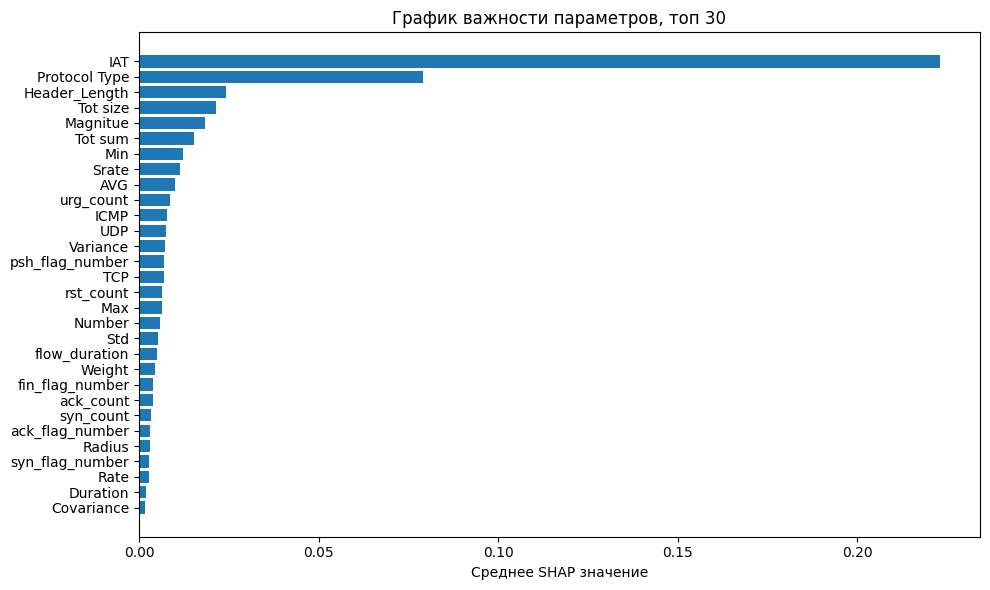

In [26]:
research_label(df_ddos, "DDoS")

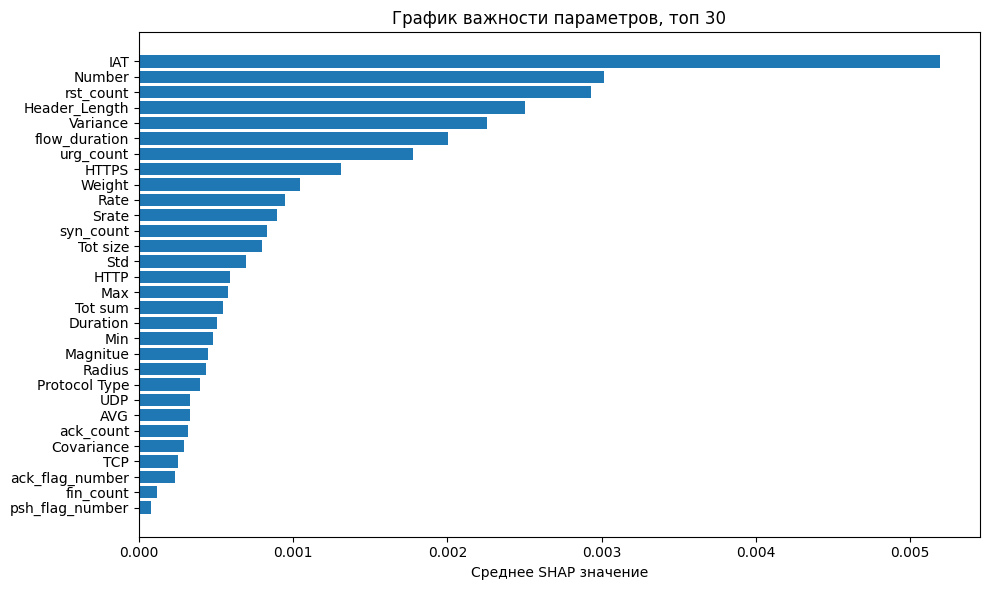

In [27]:
research_label(df_mitm, "MITM")

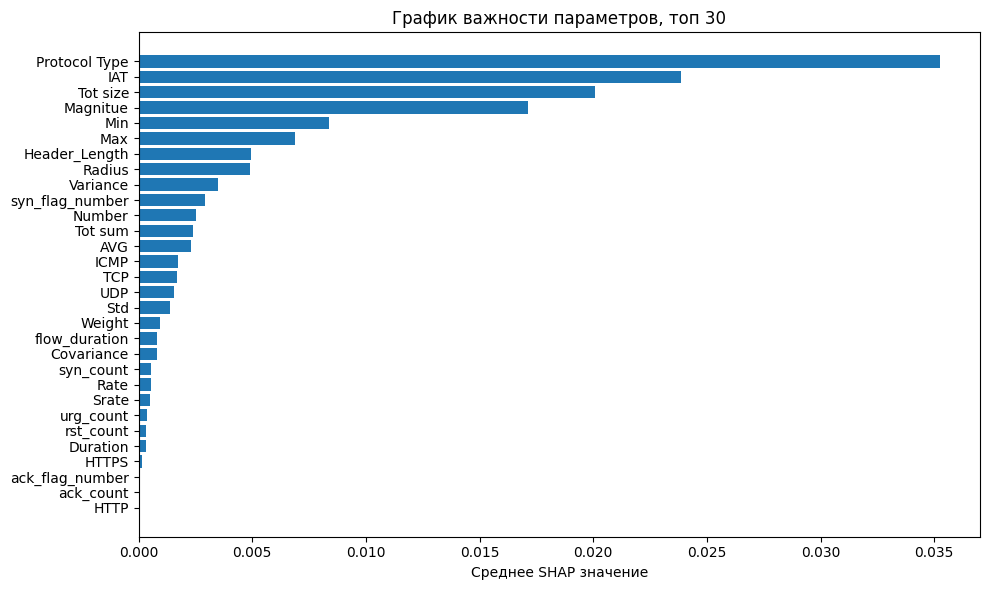

In [28]:
research_label(df_mirai, "Mirai")

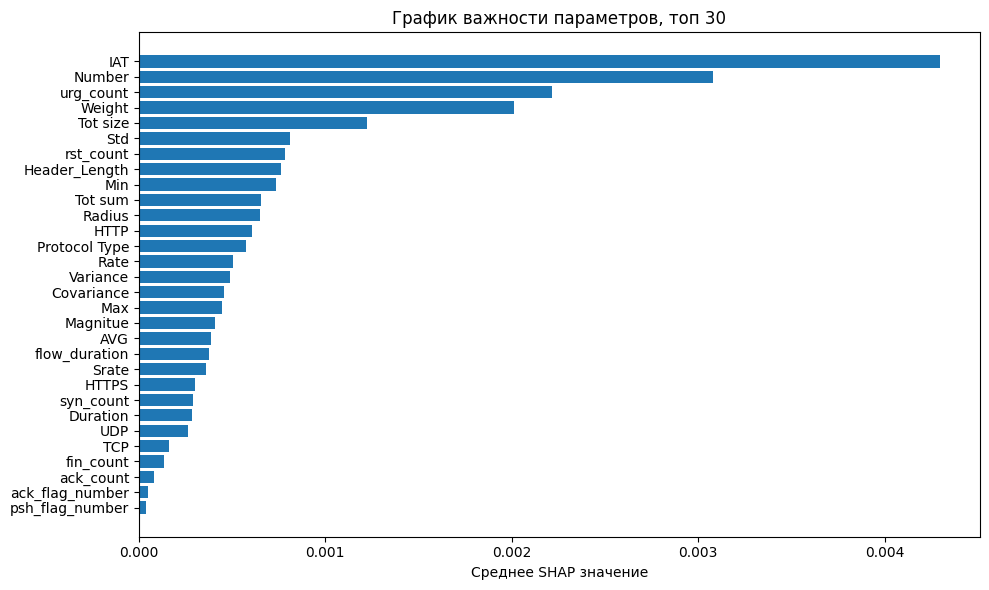

In [29]:
research_label(df_spoofing, "DNS_Spoofing")

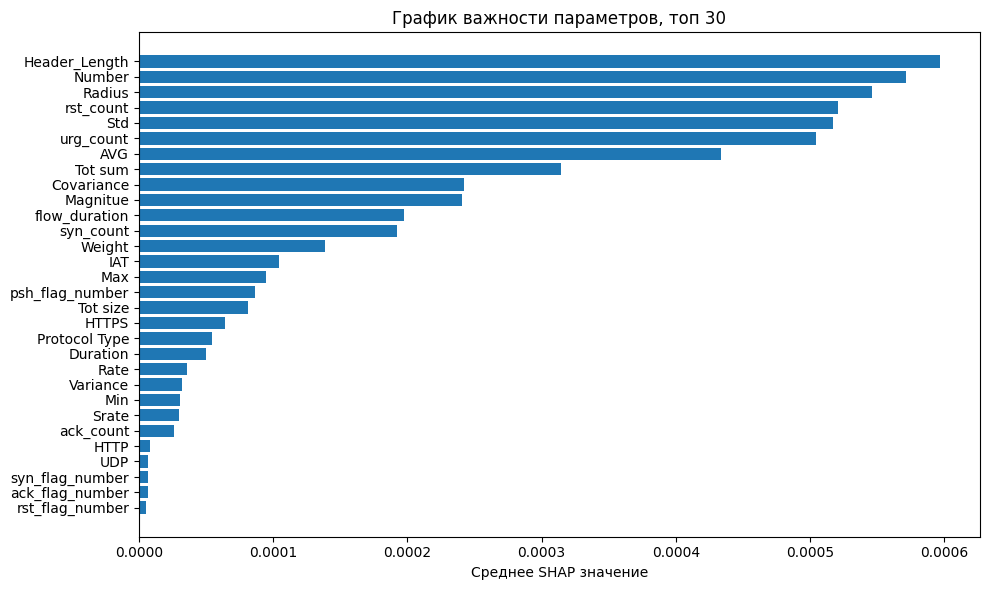

In [30]:
research_label(df_sqli, "SqlInjection")

### ДОПОЛНИТЕЛЬНО


Рассмотрим контрфактическую генерацию путём небольшого изменения фиксированного набора признаков (используя подобранные константы).

In [ ]:
X_test.describe().T.loc[ordered_features]

In [ ]:
# КОНТРФАКТИЧЕСКАЯ ГЕНЕРАЦИЯ 
def static_generator(x, model):
    """
    Генерирует контрфактический пример путём небольшого изменения фиксированного набора признаков.
    
    Параметры:
    - x: строка с признаками (Series или dict), нормализованная в диапазоне [0, 1]
    - model: обученная модель классификации

    Возвращает:
    - модифицированную строку x (контрфакт)
    - новый предсказанный класс (после изменений)
    """
    x = x.copy()  # Копируем входной пример, чтобы не менять оригинал

    # Пошагово увеличиваем значения признаков на очень малую величину,
    # при этом ограничиваем диапазон значений [0, 1] через np.clip
    x['IAT'] = np.clip(x['IAT'] + 0.0005, 0, 1)
    x['Protocol Type'] = np.clip(x['Protocol Type'] + 0.00005, 0, 1)
    x['Header_Length'] = np.clip(x['Header_Length'] + 0.00005, 0, 1)
    x['Magnitue'] = np.clip(x['Magnitue'] + 0.00005, 0, 1)
    x['AVG'] = np.clip(x['AVG'] + 0.00001, 0, 1)

    # Предсказываем новый класс после изменений
    new_class = model.predict([x])[0]

    # Возвращаем контрфакт и его предсказанный класс
    return x, new_class


In [ ]:
# ПРОВЕРКА ТОЛЬКО ДЛЯ ЦЕЛЕВОГО КЛАССА 1 

# Берём первые 100 индексов из тестовой выборки, где целевая метка равна 1 (DoS-атаки)
idx_target = y_test[y_test == 1].index[:100]

results = []           # Список для хранения результатов генерации контрфактов
successful_cfs = []    # Список успешно сгенерированных контрфактов (с изменённым классом)

# Проходим по каждому примеру из целевого класса
for i in idx_target:
    x0 = X_test.loc[i]         # Получаем строку признаков (Series)
    y_true = y_test.loc[i]     # Истинный класс
    orig_pred = model.predict([x0])[0]  # Класс, предсказанный моделью до изменений

    # Генерация контрфакта с помощью static_generator
    x_cf, cf_pred = static_generator(x0, model)

    # Если контрфакт изменил предсказание модели — сохраняем его
    if orig_pred != cf_pred:
        successful_cfs.append(x_cf)

    # Для корректного вывода делаем 2D DataFrame из исходной строки
    x1 = X_test.loc[[i]]

    # Печатаем результат: как изменился предсказанный класс
    print("\nИсходный класс:", model.predict(x1)[0], "→ Контрфакт предсказан как:", cf_pred)

    # Преобразуем исходную и изменённую строки в Series с именами признаков
    original = pd.Series(x1.values[0], index=feature_names, name="Оригинал")
    cf_series = pd.Series(x_cf, index=feature_names, name="Контрфакт")

    # Объединяем два вектора для наглядного сравнения
    comparison = pd.concat([original, cf_series], axis=1)

    # Показываем только те признаки, которые действительно были изменены
    print("\nИзменённые признаки:\n", comparison[comparison['Оригинал'] != comparison['Контрфакт']])

    # Добавляем информацию об эксперименте в итоговую таблицу
    results.append({
        'true_class': y_true,           # Истинная метка
        'original_class': orig_pred,    # Предсказание модели до изменений
        'cf_class': cf_pred,            # Предсказание модели после изменений
        'success': int(orig_pred != cf_pred)  # Флаг успешного контрфакта (1 = класс изменился)
    })

# Финальный DataFrame со статистикой по всем примерам
results_df = pd.DataFrame(results)


In [ ]:
# ОТЧЁТ 
print(f"Успешных атак на класс '1' (DoS): {results_df['success'].sum()} из {len(results_df)}")
print(results_df[['true_class', 'original_class', 'cf_class']])

In [ ]:
# МЕТРИКИ 
print("Метрики ДО:")
print(classification_report(results_df['true_class'], results_df['original_class']))
print("Метрики ПОСЛЕ:")
print(classification_report(results_df['true_class'], results_df['cf_class']))

In [ ]:
# Генерация синтетических примеров путём небольшого изменения фиксированного набора признаков
synthetic_samples = generate_synthetic_samples(successful_cfs, n_samples=100)

synthetic_preds = model.predict(synthetic_samples)
print(f"\nМодель классифицировала {sum(synthetic_preds == 1)} из 100 новых синтетических объектов как класс '1'")
